<a href="https://colab.research.google.com/github/xia0405/Master-thesis-NLP/blob/master/Tensorflow__Amazon_Word2vec_LSTM%26CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In the next notebook I use modern deep leanring to do NLP, like pre-trained word-embeddings and neural networks to do sentiment analysis of Amazon reviews. 

In [0]:
# import necessary libraries
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import pandas as pd

from gensim.models import KeyedVectors


# sklearn modules
from sklearn.metrics import accuracy_score,confusion_matrix

# Visualization modules
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

from tensorflow import keras
from keras.preprocessing import sequence

from keras.models import Sequential, load_model
#from keras.layers.embeddings import Embedding
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.optimizers import Adam
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input

In [0]:
from fastai import *
from fastai.text import *


In [0]:
# define the plot function to see the accuracy or loss along with training
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

### Load the data

In [0]:
path = Path('/content/drive/My Drive/data/amazon')
path.mkdir(parents=True, exist_ok=True)
path.ls()

[PosixPath('/content/drive/My Drive/data/amazon/smallSample_Amazon.csv'),
 PosixPath('/content/drive/My Drive/data/amazon/polarity_reviews.csv'),
 PosixPath('/content/drive/My Drive/data/amazon/train.csv'),
 PosixPath('/content/drive/My Drive/data/amazon/test.csv'),
 PosixPath('/content/drive/My Drive/data/amazon/data_lm.pkl'),
 PosixPath('/content/drive/My Drive/data/amazon/models'),
 PosixPath('/content/drive/My Drive/data/amazon/data_clas.pkl'),
 PosixPath('/content/drive/My Drive/data/amazon/word2vec'),
 PosixPath('/content/drive/My Drive/data/amazon/accuracy_total.tsv'),
 PosixPath('/content/drive/My Drive/data/amazon/CONVmodel.h5')]

In [0]:
EMBEDDING_FILE = path/'word2vec/GoogleNews-vectors-negative300.bin.gz'
MODEL_SAVING_DIR = path/'word2vec/'
LOG_DIR="/root/logs"

In [0]:
# read the data
train = pd.read_csv(path/"train.csv")
test = pd.read_csv(path/"test.csv")
train.head()

,overall,reviewText
0,0,Didn't like the fact the numbers were stitched...
1,0,"While these did protect my carbon-soled shoes,..."
2,0,Mine was another roller cut in half. I could h...
3,0,"I have to agree with Plachno on this one, but ..."
4,0,"Second pair I have, this pair has an elastic b..."


In [0]:
# Seperate the input and labels X_train, y_train, X_test, y_test
X_train, y_train = train['reviewText'].values, train['overall'].values
X_test, y_test = test['reviewText'].values, test['overall'].values

In [0]:
# print the dimensions 
print(f"X_train length: {len(X_train)}\ny_train length: {len(y_train)} \nX_test length: {len(X_test)}\ny_test length: {len(y_test)}")

X_train length: 160000
y_train length: 160000 
X_test length: 40000
y_test length: 40000


### Tokenization
I use the [**fastai** tokenizer ](https://docs.fast.ai/text.transform.html#Tokenizer) which is based on the powerful Spacy tokenizer.  
**The reason to use default fastai tokenizer is to maintain the same tokenization to compare the performances of the approaches fairly.**  
`defaults.text_pre_rules = [fix_html, replace_rep, replace_wrep, spec_add_spaces, rm_useless_spaces]`


In [0]:
tokenizer_fastai = Tokenizer()
# preprocess the reviews using class Tokenizer
tokens_train = tokenizer_fastai.process_all(X_train)
tokens_test = tokenizer_fastai.process_all(X_test)

# put tokens back to a sentence 
X_train = [' '.join(tokens_train[x]) for x in range(len(tokens_train))]
X_test = [' '.join(tokens_test[x]) for x in range(len(tokens_test))]

In [0]:
X_train[:3]

["xxmaj did n't like the fact the numbers were stitched on and the stitching started coming apart the first time out . xxmaj got a refund .",
 'xxmaj while these did protect my carbon - soled shoes , they caused me considerable problems clipping in . i had ridden eggbeaters for many years before buying these . xxmaj clipping in was second nature . xxmaj after installing these , i found it next to impossible to clip in . \n \n  xxmaj my method : \n  - xxmaj reach down , touch the pedal with my foot , toe slightly up \n  - pull foot back , hooking the back of the cleat in the pedal \n  - press down to fully engage \n \n  xxmaj all this happens quickly , while pedaling . xxmaj with these , my " pull back " hooks the pedal on the edge of the shield , instead of the cleat . \n \n  xxmaj it \'s not necessarily a bad product , just not for me .',
 "xxmaj mine was another roller cut in half . i could have done that myself - wanted something that looked more finished . xxmaj returned it to the 

**Special tokens**:
All those tokens starting with "xx" are fastai special tokens.  You can see the list of all of them and their meanings ([in the fastai docs](https://docs.fast.ai/text.transform.html)): 


---



### Numericalization 

In [0]:
# create vocabulary fom Vocab class ###https://docs.fast.ai/text.transform.html#Vocab.create
max_vocab=10000
vocab = Vocab.create(tokens_train, max_vocab=max_vocab, min_freq=5) 

In [0]:
#dict(vocab.stoi)
len(vocab.stoi)

10000

In [0]:
X_train = [vocab.numericalize(s.split()) for s in X_train]
X_test = [vocab.numericalize(s.split()) for s in X_test]

In [0]:
print(X_train[0])

[5, 76, 29, 50, 10, 559, 10, 2227, 113, 2619, 24, 15, 10, 855, 401, 711, 385, 10, 114, 87, 53, 9, 5, 121, 14, 772, 9]


Look at distribution of lengths of sentences.


In [0]:
lens = np.array([len(review) for review in X_train])

In [0]:
len(X_train[0])

27

In [0]:
(lens.max(), lens.min(), lens.mean())

(3292, 1, 66.77198125)

The max length of a review is 3292 while the average length of reviews is 67.

##### Import word2vec

Embeddings are stored as a |V|×D matrix, where |V| is the lenght of vocabulary and D is the dimensionality of the embeddings, such that the word assigned index i has its embedding stored in the i’th row of the matrix.

In [0]:
# Import pre-trained google word2vec embeddings
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
embedding_dim = 300

def create_emb():
  embeddings = np.zeros((max_vocab, embedding_dim))
  # Build the embedding matrix
  for word, index in vocab.stoi.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)
    else:
        # If we can't find the word in word2vec, randomly initialize
        embeddings[index] = np.random.normal(scale=0.6, size=(embedding_dim,))
  return embeddings


embeddings = create_emb()

In [0]:
embeddings.shape

(10000, 300)

In [0]:
[embeddings]

[array([[ 0.511704,  0.166728,  0.558543, -0.004259, ..., -0.003976, -0.024881,  0.91207 , -1.088309],
        [ 0.138319,  0.294926,  0.518487, -0.806896, ...,  0.059941, -0.918346,  0.956491,  0.102017],
        [ 0.510431,  0.519116, -0.520446,  0.682543, ...,  0.400588,  1.900472,  0.049683,  1.679115],
        [ 0.509402, -0.667268, -0.77839 , -0.111253, ..., -0.259485, -0.01718 , -0.689634, -0.239971],
        ...,
        [ 0.083984,  0.291016,  0.19043 , -0.125977, ..., -0.18457 , -0.083496,  0.160156,  0.058105],
        [ 0.02002 ,  0.103027, -0.0354  ,  0.341797, ...,  0.292969,  0.18457 , -0.131836, -0.119629],
        [ 0.07666 , -0.068848, -0.032715,  0.361328, ...,  0.11377 , -0.310547, -0.283203,  0.09082 ],
        [ 0.047119, -0.014954,  0.050049, -0.170898, ...,  0.100098, -0.137695,  0.094727,  0.28125 ]])]

##### Load the X_train,X_test,y_train,y_test to tensorflow with tf.data.Dataset
- convert texts to numbers  
- pad sequence  
In order to feed this data into our RNN, all input documents must have the same length. We will limit the maximum review length to max_words by truncating longer reviews and padding shorter reviews with a null value (0). We can accomplish this using the pad_sequences() function in Keras.

In [0]:
MAX_SEQUENCE_LENGTH = 100
train_data= sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
train_labels = np.array(y_train)
print('Shape of training data tensor:', train_data.shape)
print('Shape of training label tensor:', train_labels.shape)

test_data = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
test_labels = np.array(y_test)

print('Shape of test data tensor:', test_data.shape)
print('Shape of test label tensor:', test_labels.shape)

Shape of training data tensor: (160000, 100)
Shape of training label tensor: (160000,)
Shape of test data tensor: (40000, 100)
Shape of test label tensor: (40000,)


## Train the model

Convolution is classically used to extract features from images.From the paper of Yoon Kim (2014, Convolutional Neural Networks for Sentence Classification) Conv speeds up quite a lot the training speed and the results are good. 


In [0]:
model = Sequential([
    Embedding(max_vocab, embedding_dim, input_length=MAX_SEQUENCE_LENGTH, weights=[embeddings],trainable=False),
    Convolution1D(64, 5, padding='same', activation='relu'),
    Dropout(0.2),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 64)           96064     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               320100    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)              

##### experiment 1:

In [0]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [0]:
# to save the best model along training to avoid any interuption.
bst_model_path = path/"model.h5"
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True)

In [0]:
optimizer._decayed_lr(tf.float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.0007684335>

In [0]:
# Fit the model with learning rate decay and bs 64
%%time
history = model.fit(train_data, train_labels,
                    batch_size = 64, 
                    epochs=20, 
                    shuffle=True, 
                    validation_data=(test_data,test_labels),
                    callbacks= [model_checkpoint])

Train on 160000 samples, validate on 40000 samples
Epoch 1/20
160000/160000 [==============================] - 26s 162us/step - loss: 0.4666 - accuracy: 0.7669 - val_loss: 0.3570 - val_accuracy: 0.8449
Epoch 2/20
160000/160000 [==============================] - 26s 161us/step - loss: 0.3536 - accuracy: 0.8463 - val_loss: 0.3231 - val_accuracy: 0.8595
Epoch 3/20
160000/160000 [==============================] - 26s 161us/step - loss: 0.3227 - accuracy: 0.8624 - val_loss: 0.3051 - val_accuracy: 0.8702
Epoch 4/20
160000/160000 [==============================] - 27s 172us/step - loss: 0.3048 - accuracy: 0.8717 - val_loss: 0.2908 - val_accuracy: 0.8780
Epoch 5/20
160000/160000 [==============================] - 28s 173us/step - loss: 0.2872 - accuracy: 0.8794 - val_loss: 0.2883 - val_accuracy: 0.8796
Epoch 6/20
160000/160000 [==============================] - 27s 167us/step - loss: 0.2760 - accuracy: 0.8854 - val_loss: 0.2807 - val_accuracy: 0.8831
Epoch 7/20
160000/160000 [=================

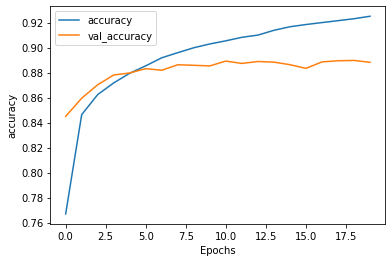

In [0]:
plot_graphs(history,'accuracy')

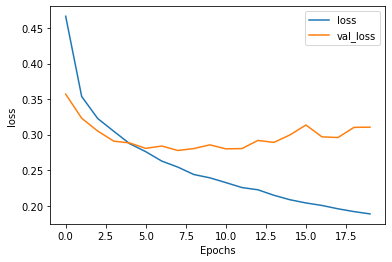

In [0]:
plot_graphs(history, 'loss')

In [0]:
# learning rate decay
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=5000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)   #keras.optimizers.SGD

# compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [0]:
# Fit the model
%%time
history = model.fit(train_data, train_labels,
                    batch_size = 64, 
                    epochs=5, 
                    shuffle=True, 
                    validation_data=(test_data,test_labels),
                    callbacks= [model_checkpoint])

Train on 160000 samples, validate on 40000 samples
Epoch 1/5
160000/160000 [==============================] - 23s 146us/step - loss: 0.1719 - accuracy: 0.9323 - val_loss: 0.3117 - val_accuracy: 0.8905
Epoch 2/5
160000/160000 [==============================] - 24s 151us/step - loss: 0.1685 - accuracy: 0.9334 - val_loss: 0.3132 - val_accuracy: 0.8914
Epoch 3/5
160000/160000 [==============================] - 24s 152us/step - loss: 0.1676 - accuracy: 0.9340 - val_loss: 0.3139 - val_accuracy: 0.8915
Epoch 4/5
160000/160000 [==============================] - 25s 158us/step - loss: 0.1658 - accuracy: 0.9357 - val_loss: 0.3134 - val_accuracy: 0.8916
Epoch 5/5
160000/160000 [==============================] - 24s 152us/step - loss: 0.1656 - accuracy: 0.9353 - val_loss: 0.3139 - val_accuracy: 0.8915
CPU times: user 1min 42s, sys: 21.8 s, total: 2min 4s
Wall time: 2min 1s


In [0]:
# Fit the model
%%time
history = model.fit(train_data, train_labels,
                    batch_size = 64, 
                    epochs=5, 
                    shuffle=True, 
                    validation_data=(test_data,test_labels),
                    callbacks= [model_checkpoint])

Train on 160000 samples, validate on 40000 samples
Epoch 1/5
160000/160000 [==============================] - 34s 211us/step - loss: 0.4565 - accuracy: 0.7776 - val_loss: 0.3830 - val_accuracy: 0.8209
Epoch 2/5
160000/160000 [==============================] - 28s 172us/step - loss: 0.3505 - accuracy: 0.8476 - val_loss: 0.3141 - val_accuracy: 0.8651
Epoch 3/5
160000/160000 [==============================] - 26s 165us/step - loss: 0.3201 - accuracy: 0.8629 - val_loss: 0.3041 - val_accuracy: 0.8706
Epoch 4/5
160000/160000 [==============================] - 26s 164us/step - loss: 0.3020 - accuracy: 0.8720 - val_loss: 0.2907 - val_accuracy: 0.8766
Epoch 5/5
160000/160000 [==============================] - 27s 166us/step - loss: 0.2861 - accuracy: 0.8802 - val_loss: 0.2877 - val_accuracy: 0.8798
CPU times: user 1min 57s, sys: 22.9 s, total: 2min 20s
Wall time: 2min 21s


We decrease the learning rate now that we are getting closer to the answer.

In [0]:
model.optimizer.lr=1e-4

AttributeError: ignored

##### experiment 2:

In [0]:
# to save the best model along training to avoid any interuption.
bst_model_path = "/content/drive/My Drive/data/amazon/CONVmodel.h5"
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True)

In [0]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [0]:
# Fit the model with learning rate decay and bs 128
%%time
history_CONV = model.fit(train_data, train_labels,
                    batch_size = 128, 
                    epochs=20, 
                    shuffle=True, 
                    validation_data=(test_data,test_labels),
                    callbacks= [model_checkpoint])

Train on 160000 samples, validate on 40000 samples
Epoch 1/20
160000/160000 [==============================] - 15s 94us/step - loss: 0.4805 - accuracy: 0.7553 - val_loss: 0.3586 - val_accuracy: 0.8417
Epoch 2/20
160000/160000 [==============================] - 15s 94us/step - loss: 0.3525 - accuracy: 0.8466 - val_loss: 0.3349 - val_accuracy: 0.8547
Epoch 3/20
160000/160000 [==============================] - 15s 93us/step - loss: 0.3242 - accuracy: 0.8620 - val_loss: 0.3102 - val_accuracy: 0.8679
Epoch 4/20
160000/160000 [==============================] - 15s 92us/step - loss: 0.3053 - accuracy: 0.8702 - val_loss: 0.3087 - val_accuracy: 0.8663
Epoch 5/20
160000/160000 [==============================] - 16s 98us/step - loss: 0.2885 - accuracy: 0.8779 - val_loss: 0.2858 - val_accuracy: 0.8810
Epoch 6/20
160000/160000 [==============================] - 17s 104us/step - loss: 0.2741 - accuracy: 0.8852 - val_loss: 0.2853 - val_accuracy: 0.8799
Epoch 7/20
160000/160000 [======================

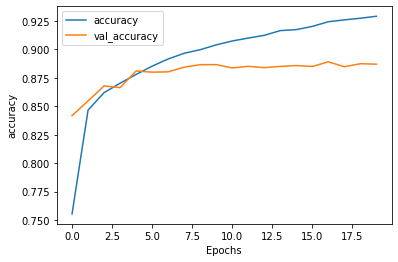

In [0]:
plot_graphs(history_CONV,'accuracy')

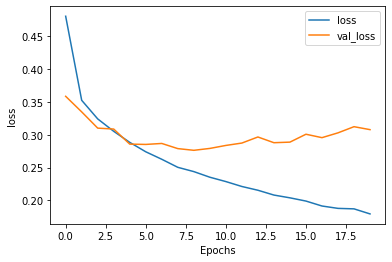

In [0]:
plot_graphs(history_CONV, 'loss')

In [0]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

In [0]:
# Fit the model with learning rate decay and bs 128
%%time
history_CONV = model.fit(train_data, train_labels,
                    batch_size = 128, 
                    epochs=10, 
                    shuffle=True, 
                    validation_data=(test_data,test_labels),
                    callbacks= [model_checkpoint])

NameError: ignored

#### experiment 3:

In [0]:
Conv_model = Sequential([
    Embedding(max_vocab, embedding_dim, input_length=MAX_SEQUENCE_LENGTH, weights=[embeddings],trainable=False),
    Convolution1D(128, 5, padding='same', activation='relu'),
    Dropout(0.5),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

print(Conv_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 128)          192128    
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               640100    
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)              

In [0]:
# to save the best model along training to avoid any interuption.
bst_model_path = "/content/drive/My Drive/data/amazon/CONVmodel_2.h5"
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True)

In [0]:
# compile the model
Conv_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [0]:
# Fit the model with bs 64
%%time
history_CONV_2 = Conv_model.fit(train_data, train_labels,
                    batch_size = 64, 
                    epochs=20, 
                    shuffle=True, 
                    validation_data=(test_data,test_labels),
                    callbacks= [model_checkpoint])

Train on 160000 samples, validate on 40000 samples
Epoch 1/20
160000/160000 [==============================] - 33s 203us/step - loss: 0.4946 - accuracy: 0.7514 - val_loss: 0.3836 - val_accuracy: 0.8298
Epoch 2/20
160000/160000 [==============================] - 26s 165us/step - loss: 0.3844 - accuracy: 0.8292 - val_loss: 0.3488 - val_accuracy: 0.8505
Epoch 3/20
160000/160000 [==============================] - 26s 162us/step - loss: 0.3523 - accuracy: 0.8478 - val_loss: 0.3192 - val_accuracy: 0.8669
Epoch 4/20
160000/160000 [==============================] - 26s 161us/step - loss: 0.3338 - accuracy: 0.8568 - val_loss: 0.3079 - val_accuracy: 0.8712
Epoch 5/20
160000/160000 [==============================] - 26s 161us/step - loss: 0.3196 - accuracy: 0.8632 - val_loss: 0.2960 - val_accuracy: 0.8781
Epoch 6/20
160000/160000 [==============================] - 26s 161us/step - loss: 0.3076 - accuracy: 0.8700 - val_loss: 0.2956 - val_accuracy: 0.8746
Epoch 7/20
160000/160000 [=================

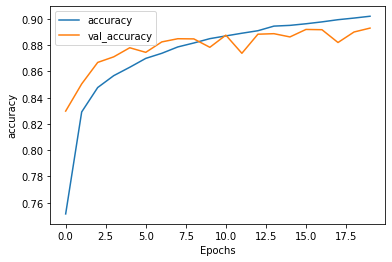

In [0]:
plot_graphs(history_CONV_2,'accuracy')

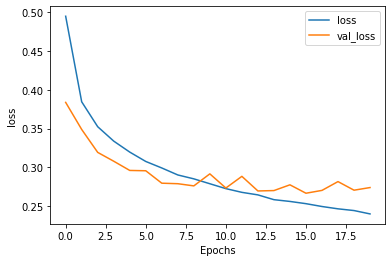

In [0]:
plot_graphs(history_CONV_2, 'loss')

In [0]:
# compile the model
Conv_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])


In [0]:
# Fit the model with bs 64
%%time
history_CONV_3 = Conv_model.fit(train_data, train_labels,
                    batch_size = 64, 
                    epochs=5, 
                    shuffle=True, 
                    validation_data=(test_data,test_labels),
                    callbacks= [model_checkpoint])

Train on 160000 samples, validate on 40000 samples
Epoch 1/5
160000/160000 [==============================] - 26s 164us/step - loss: 0.2204 - accuracy: 0.9106 - val_loss: 0.2647 - val_accuracy: 0.8959
Epoch 2/5
160000/160000 [==============================] - 26s 163us/step - loss: 0.2115 - accuracy: 0.9150 - val_loss: 0.2626 - val_accuracy: 0.8987
Epoch 3/5
160000/160000 [==============================] - 26s 164us/step - loss: 0.2073 - accuracy: 0.9163 - val_loss: 0.2637 - val_accuracy: 0.8978
Epoch 4/5
160000/160000 [==============================] - 26s 165us/step - loss: 0.2072 - accuracy: 0.9169 - val_loss: 0.2647 - val_accuracy: 0.8960
Epoch 5/5
160000/160000 [==============================] - 26s 162us/step - loss: 0.2034 - accuracy: 0.9181 - val_loss: 0.2637 - val_accuracy: 0.8987
CPU times: user 1min 46s, sys: 24.4 s, total: 2min 11s
Wall time: 2min 16s


In [0]:
# compile the model
Conv_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=5e-5), metrics=['accuracy'])


In [0]:
# Fit the model with bs 64
%%time
history_CONV_3 = Conv_model.fit(train_data, train_labels,
                    batch_size = 64, 
                    epochs=5, 
                    shuffle=True, 
                    validation_data=(test_data,test_labels),
                    callbacks= [model_checkpoint])

Train on 160000 samples, validate on 40000 samples
Epoch 1/5
160000/160000 [==============================] - 26s 164us/step - loss: 0.2021 - accuracy: 0.9193 - val_loss: 0.2649 - val_accuracy: 0.8981
Epoch 2/5
160000/160000 [==============================] - 26s 162us/step - loss: 0.2010 - accuracy: 0.9193 - val_loss: 0.2644 - val_accuracy: 0.8987
Epoch 3/5
160000/160000 [==============================] - 26s 165us/step - loss: 0.2009 - accuracy: 0.9191 - val_loss: 0.2655 - val_accuracy: 0.8982
Epoch 4/5
160000/160000 [==============================] - 26s 162us/step - loss: 0.1993 - accuracy: 0.9211 - val_loss: 0.2648 - val_accuracy: 0.8992
Epoch 5/5
160000/160000 [==============================] - 26s 162us/step - loss: 0.1991 - accuracy: 0.9204 - val_loss: 0.2656 - val_accuracy: 0.8974
CPU times: user 1min 45s, sys: 24.1 s, total: 2min 9s
Wall time: 2min 11s


#### experiment 4:
Bidirectional LSTM MODELS

In [0]:

lstm_model = Sequential()

embedding_layer = Embedding(input_dim=max_vocab, output_dim=embedding_dim, input_length=MAX_SEQUENCE_LENGTH, weights=[embeddings],trainable=False) #, input_length=MAX_SEQUENCE_LENGTH, trainable=False, embeddings_initializer= embeddings,
lstm_layer = Bidirectional(LSTM(32))

lstm_model.add(embedding_layer)
lstm_model.add(lstm_layer)
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

print(lstm_model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                85248     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 3,085,313
Trainable params: 85,313
Non-trainable params: 3,000,000
_________________________________________________________________
None


In [0]:
# compile the model
lstm_model.compile(loss='binary_crossentropy', 
             optimizer=Adam(), 
             metrics=['accuracy'])

In [0]:
# Fit the model
%%time
history_lstm = lstm_model.fit(train_data, train_labels,
                    batch_size = 128, 
                    epochs=10, 
                    shuffle=True, 
                    validation_data=(test_data,test_labels),
                    callbacks= [model_checkpoint])

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 657s 4ms/step - loss: 0.4352 - accuracy: 0.7981 - val_loss: 0.3662 - val_accuracy: 0.8310
Epoch 2/10
160000/160000 [==============================] - 652s 4ms/step - loss: 0.3442 - accuracy: 0.8516 - val_loss: 0.3333 - val_accuracy: 0.8603
Epoch 3/10
160000/160000 [==============================] - 653s 4ms/step - loss: 0.3031 - accuracy: 0.8735 - val_loss: 0.2809 - val_accuracy: 0.8801
Epoch 4/10
160000/160000 [==============================] - 647s 4ms/step - loss: 0.2769 - accuracy: 0.8861 - val_loss: 0.2778 - val_accuracy: 0.8852
Epoch 5/10
160000/160000 [==============================] - 648s 4ms/step - loss: 0.2622 - accuracy: 0.8936 - val_loss: 0.2575 - val_accuracy: 0.8930
Epoch 6/10
160000/160000 [==============================] - 652s 4ms/step - loss: 0.2501 - accuracy: 0.8998 - val_loss: 0.2513 - val_accuracy: 0.8967
Epoch 7/10
160000/160000 [=======================

Load the model and continue to train

In [0]:
from numpy.testing import assert_allclose

In [0]:
# load the model
new_model_lstm = load_model("model.h5")
assert_allclose(lstm_model.predict(X_train),
                new_model_lstm.predict(X_train),
                1e-5)



ValueError: ignored

In [0]:
#new_model_lstm.optimizer.lr=1e-4
# learning rate decay
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=5000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)   #keras.optimizers.SGD

# compile the model
new_model_lstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# callback and save the best model
model_checkpoint = ModelCheckpoint("model_20200610.h5",  save_best_only=True)

In [0]:
# fit the model
%%time
history_lstm_new = new_model_lstm.fit(train_data, train_labels,
                    batch_size = 128, 
                    epochs=5, 
                    shuffle=True, 
                    validation_data=(test_data,test_labels),
                    callbacks= [model_checkpoint])

Train on 160000 samples, validate on 40000 samples
Epoch 1/5
160000/160000 [==============================] - 686s 4ms/step - loss: 0.2033 - accuracy: 0.9210 - val_loss: 0.2379 - val_accuracy: 0.9044
Epoch 2/5


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


160000/160000 [==============================] - 686s 4ms/step - loss: 0.2032 - accuracy: 0.9211 - val_loss: 0.2379 - val_accuracy: 0.9045
Epoch 3/5
160000/160000 [==============================] - 633s 4ms/step - loss: 0.2031 - accuracy: 0.9208 - val_loss: 0.2376 - val_accuracy: 0.9046
Epoch 4/5
160000/160000 [==============================] - 624s 4ms/step - loss: 0.2031 - accuracy: 0.9205 - val_loss: 0.2374 - val_accuracy: 0.9044
Epoch 5/5
160000/160000 [==============================] - 633s 4ms/step - loss: 0.2020 - accuracy: 0.9212 - val_loss: 0.2376 - val_accuracy: 0.9043
CPU times: user 1h 18min 35s, sys: 11min 29s, total: 1h 30min 4s
Wall time: 54min 24s


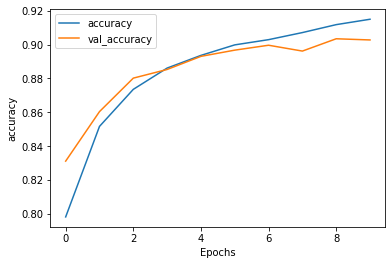

In [0]:
plot_graphs(history_lstm,'accuracy')

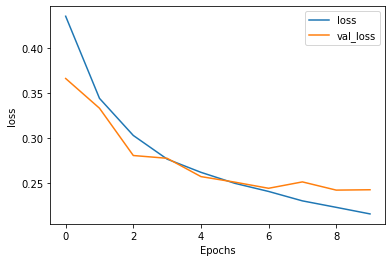

In [0]:
plot_graphs(history_lstm, 'loss')